# Разработка модели предсказания потери почтовых отправлений

## г. Иннополис. Всероссийский чемпионат

### 26 октября — 25 ноября 2022 г.

## Задача

### Условие задачи

Разработка модели предсказания потери почтовых отправлений.


### Описание входных значений

    ● train.csv — файл, содержащий данные о посылках, включая статус
    отправления;
    ● test.csv — файл, содержащий данные о посылках для предсказания ;
    ● sample_solution.csv — пример файла для отправки;

    Расшифровка столбцов 

        Наименование поля   - Описание данных 
    1 	oper_type + oper_attr   - Тип и атрибут операции 
    2 	index_oper   - Индекс места операции 
    3 	type   - Обозначение типа объекта почтовой связи 
    4 	priority   - Приоритет объекта 
    5 	is_privatecategory   - Y - является отделением закрытого типа, N - иначе 
    6 	class   - Значение класса или категории объекта почтовой связи 
    7 	is_in_yandex  - Y - адрес отделения связи отображается в Яндекс-картах, N - иначе 
    8 	is_return   - Y - Отправление движется в направлении возврата отправителю, N - иначе 
    9 	weight   - Вес в граммах 
    10 	mailtype   - Код вида отправления 
    11 	mailctg   - Код категории почтового отправления 
    12 	mailrank   - Код разряда почтового отправления 
    13 	directctg   - Код классификации отправления 
    14 	transport_pay   - Общая сумма платы за пересылку в условной валюте 
    15 	postmark   - Код отметки 
    16 	name_mfi   - Наименование вложений (указано через запятую), указывается на бирке отправления 
    17 	weight_mfi   - Суммарная масса вложений 
    18 	price_mfi   - Суммарная стоимость вложений в условной валюте 
    19 	dist_qty_oper_login_1   - Количество уникальных имен операторов, задействованных в обработке данного типа отправлений (mailtype) на конкретном индексе, по которым возможно идентифицировать оператора 
    20 	total_qty_oper_login_1 	- Количество отправлений с уникальным именем операторов, задействованных в обработке данного типа отправлений (mailtype) на конкретном индексе, по которым возможно идентифицировать оператора 
    21 	total_qty_oper_login_0 	 - Количество отправлений данного типа (mailtype), которые были обработаны неизвестным ператором на этом индексе 
    22 	total_qty_over_index_and_type 	- Общее количество отправлений данного типа (mailtype), прошедших обработку на этом     индексе 
    23 	total_qty_over_index  - Общее количество отправлений, прошедших обработку на этом индексе 
    24 	is_wrong_sndr_name 	- Есть ли явные признаки, что имя отправителя введено некорректно? 1 - да, 0 - иначе 
    25 	is_wrong_rcpn_name 	- Есть ли явные признаки, что имя получателя введено некорректно? 1 - да, 0 - иначе 
    26 	is_wrong_phone_number  - Есть ли явные признаки, что номер телефона получателя введен некорректно? 1-да, 0-иначе 
    27 	is_wrong_address  - Есть ли явные признаки, что адрес получателя введен некорректно? 1 - да, 0 - иначе 
    28 	label  - СТРОКА ДЛЯ ПРЕДСКАЗАНИЯ 
        1 - операция, на которой цифровой след оборвался, т.к. отправление потеряно 
        0 - отправление было вручено или возвращено отправителю 


### Метрика
В качестве метрики выступает комбинация двух значений:
Результирующее значение выглядит как:

    Result = 0.1 * Recall + 0.9 * AUC_ROC


## Загрузка библиотек и данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import time
start_time = time.time()

In [4]:
train_df = pd.read_csv("train_dataset_train.csv")
test_df = pd.read_csv("test_dataset_test.csv")

In [5]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 42.59305715560913 seconds ---


### Оптимизация памяти 

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            #df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [7]:
reduce_mem_usage(train_df)

Memory usage of dataframe is 1327.51 MB
Memory usage after optimization is: 503.09 MB
Decreased by 62.1%


,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629.0,Участок,7503.0,N,0.0,Y,N,87.0,...,42.0,720176.0,58950.0,779126.0,8290896.0,0,0,0,0,0
1,9907176,1023_-1,102976.0,ММПО,7503.0,N,0.0,N,N,107.0,...,914.0,48856656.0,83318928.0,132175592.0,136819808.0,0,0,0,0,0
2,3304275,1018_-1,620962.0,Цех,7503.0,N,0.0,Y,N,50.0,...,62.0,3246292.0,3233068.0,6479360.0,52708072.0,0,1,0,0,0
3,9020937,1019_-1,344964.0,Цех,7503.0,N,0.0,Y,N,416.0,...,55.0,2060928.0,653280.0,2714208.0,19562334.0,0,0,0,0,0
4,3082311,1020_-1,629819.0,Участок,7503.0,N,0.0,Y,N,795.0,...,16.0,316919.0,27911.0,344830.0,4719186.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5999995,9958614,1022_-1,102976.0,ММПО,7503.0,N,0.0,N,N,25.0,...,1089.0,64270132.0,116432632.0,180702768.0,188407808.0,0,0,1,0,0
5999996,2234489,1022_-1,241963.0,Цех,7503.0,N,0.0,Y,N,83.0,...,31.0,1767370.0,144063.0,1911433.0,15582018.0,0,0,0,0,0
5999997,4304572,1041_-1,102971.0,Цех,7506.0,N,0.0,N,N,1700.0,...,186.0,60613352.0,10648.0,60624000.0,75592384.0,0,0,0,0,0
5999998,6550634,1018_-1,102152.0,Цех,7506.0,N,0.0,N,N,269.0,...,105.0,15091338.0,4972424.0,20063762.0,39988528.0,0,1,0,0,0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000000 entries, 0 to 5999999
Data columns (total 29 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   id                             int32   
 1   oper_type + oper_attr          category
 2   index_oper                     category
 3   type                           category
 4   priority                       float32 
 5   is_privatecategory             category
 6   class                          float32 
 7   is_in_yandex                   category
 8   is_return                      category
 9   weight                         float32 
 10  mailtype                       float32 
 11  mailctg                        float32 
 12  mailrank                       float32 
 13  directctg                      float32 
 14  transport_pay                  float32 
 15  postmark                       float32 
 16  name_mfi                       category
 17  weight_mfi                 

In [9]:
reduce_mem_usage(test_df)

Memory usage of dataframe is 854.49 MB
Memory usage after optimization is: 335.16 MB
Decreased by 60.8%


,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address
0,7815282,8_13,102976.0,ММПО,7503.0,N,0.0,N,N,85.0,...,489.0,972.0,68766048.0,91123248.0,159889296.0,164927296.0,0,0,0,0
1,8443555,8_2,238753.0,ГОПС,7503.0,N,4.0,Y,N,21.0,...,186.0,2.0,2895.0,1545.0,4440.0,20623.0,0,1,1,0
2,6352559,1020_-1,618254.0,ГОПС,7503.0,N,4.0,Y,N,388.0,...,500.0,3.0,2751.0,993.0,3744.0,37817.0,0,0,0,0
3,4921420,1016_-1,102968.0,ТИ,7503.0,N,0.0,N,N,1203.0,...,0.0,69.0,9379609.0,2267333.0,11646942.0,11759329.0,0,1,0,0
4,1420440,1018_-1,102971.0,Цех,7506.0,N,0.0,N,N,956.0,...,1267.0,181.0,76138192.0,8747.0,76146936.0,84110456.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,9030800,1017_1001,655003.0,ГОПС,7503.0,N,4.0,Y,N,53.0,...,262.0,3.0,4297.0,1803.0,6100.0,64613.0,0,0,0,0
3999996,6275048,1023_-1,102976.0,ММПО,7503.0,N,0.0,N,N,286.0,...,0.0,914.0,48856656.0,83318928.0,132175592.0,136819808.0,0,1,0,0
3999997,4701757,1022_-1,102969.0,ТИ,7503.0,N,0.0,N,N,733.0,...,300.0,106.0,17348074.0,3469387.0,20817460.0,20821108.0,0,1,0,0
3999998,611153,39_-1,104006.0,Участок,7503.0,N,0.0,N,N,265.0,...,500.0,2.0,15.0,13673720.0,13673735.0,14041298.0,0,0,0,0


### Балансировка

label
0    5829020
1     170980
dtype: int64


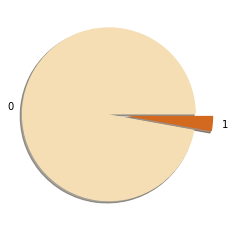

In [10]:
plt.pie(train_df['label'].value_counts(), labels=[0, 1], colors=['wheat', 'chocolate'], explode=[0.1, 0.1], shadow=True)
print(train_df.value_counts('label'));

In [11]:
# Балансировка

def balans_01(df, field, plot = 0):
    """ функция принимает датафрейм df и возвращает датафрейм сбалансированный
    по минимальному значению поля field (значения 0/1) 
    Пример вызова df_train = balans_01(df_train,'blocked', plot = 1)"""
    df_0 = df[df[field]==0]    
    df_1 = df[df[field]==1]
    if len(df_0) < len(df_1):
        df_1 = df_1.sample(n=len(df_0), random_state=101)
    else:
        df_0 = df_0.sample(n=len(df_1), random_state=101)
    df = pd.concat([df_0,df_1],axis=0)
    
    if plot == 1:
        plt.pie(df[field].value_counts(), labels=[0, 1], colors=['wheat', 'chocolate'], explode=[0.1, 0.1], shadow=True)
        print(df.value_counts(field));
    
    return df

In [12]:
train_df = balans_01(train_df,'label', plot = 0)

## Исследование данных

In [13]:
def eda(df):
    """ функция выводит основные характеристики датафрейма """
    print(df.head())
    print('\n info()')
    print(df.info())
    print('\n describe()')
    print(df.describe())
    print('\n nunique()')
    print(df.nunique())

In [14]:
eda(train_df)

              id oper_type + oper_attr index_oper     type  priority  \
5759084  8763005                  1_-1     102971      Цех    7506.0   
859207   8994944               1001_-1   200980.0      Цех    7503.0   
4361168  2183191               1001_-1   163960.0      МСЦ    7503.0   
3540663  4025456               1001_-1   610962.0  Участок    7503.0   
1965130  5252744               1043_-1     454962  Участок    7503.0   

        is_privatecategory  class is_in_yandex is_return  weight  ...  \
5759084                  N    0.0            N         N    38.0  ...   
859207                   N    0.0            Y         N    75.0  ...   
4361168                  N    0.0            Y         N    28.0  ...   
3540663                  N    0.0            Y         N   134.0  ...   
1965130                  N    0.0            Y         N    14.0  ...   

         dist_qty_oper_login_1  total_qty_oper_login_1  \
5759084                  153.0              89268736.0   
859207      

In [15]:
train_df.head(3)

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
5759084,8763005,1_-1,102971,Цех,7506.0,N,0.0,N,N,38.0,...,153.0,89268736.0,6799759.0,96068496.0,101200376.0,0,0,1,0,0
859207,8994944,1001_-1,200980.0,Цех,7503.0,N,0.0,Y,N,75.0,...,107.0,10782597.0,20647.0,10803244.0,116342696.0,0,0,1,0,0
4361168,2183191,1001_-1,163960.0,МСЦ,7503.0,N,0.0,Y,N,28.0,...,66.0,1895958.0,204133.0,2100091.0,20360616.0,0,0,0,0,0


array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'priority'}>,
        <AxesSubplot:title={'center':'class'}>,
        <AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'mailtype'}>],
       [<AxesSubplot:title={'center':'mailctg'}>,
        <AxesSubplot:title={'center':'mailrank'}>,
        <AxesSubplot:title={'center':'directctg'}>,
        <AxesSubplot:title={'center':'transport_pay'}>,
        <AxesSubplot:title={'center':'postmark'}>],
       [<AxesSubplot:title={'center':'weight_mfi'}>,
        <AxesSubplot:title={'center':'price_mfi'}>,
        <AxesSubplot:title={'center':'dist_qty_oper_login_1'}>,
        <AxesSubplot:title={'center':'total_qty_oper_login_1'}>,
        <AxesSubplot:title={'center':'total_qty_oper_login_0'}>],
       [<AxesSubplot:title={'center':'total_qty_over_index_and_type'}>,
        <AxesSubplot:title={'center':'total_qty_over_index'}>,
        <AxesSubplot:title={'center':'is_wrong_sndr_name'}>

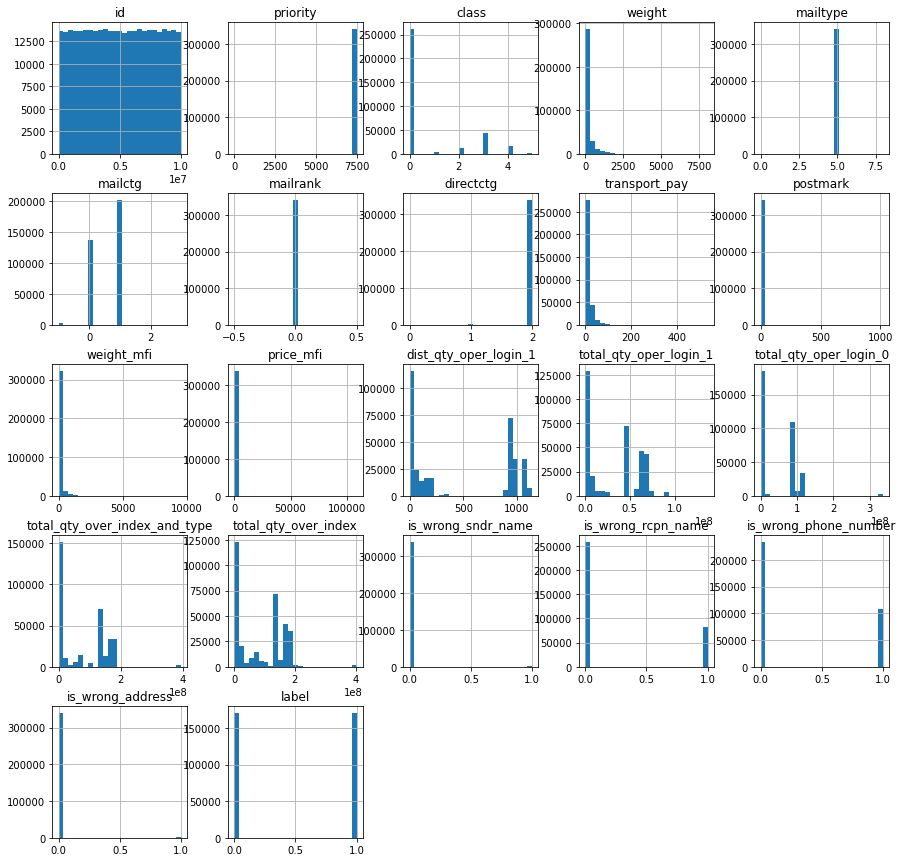

In [16]:
df_num = train_df.select_dtypes(include=['int8', 'int16','int32', 'float32'])
#df_num = df_train.select_dtypes(include=['float32','float64'])
df_num.hist(figsize=(15,15), bins=25, grid=True)

Рассмотрим часть столбцов типа "object"

In [17]:
train_df["is_in_yandex"].value_counts()

N    216338
Y    125535
0        87
Name: is_in_yandex, dtype: int64

In [18]:
train_df["is_return"].value_counts()

N    341600
Y       360
Name: is_return, dtype: int64

Эти категории можно сделать ранговыми 

In [19]:
train_df["is_privatecategory"] = pd.Categorical(train_df["is_privatecategory"])
train_df["is_privatecategory"].astype('category').cat.codes
train_df["is_privatecategory"] = train_df["is_privatecategory"].cat.codes

In [20]:
train_df["is_in_yandex"] = pd.Categorical(train_df["is_in_yandex"])
train_df["is_in_yandex"].astype('category').cat.codes
train_df["is_in_yandex"] = train_df["is_in_yandex"].cat.codes

In [21]:
train_df["is_return"] = pd.Categorical(train_df["is_return"])
train_df["is_return"].astype('category').cat.codes
train_df["is_return"] = train_df["is_return"].cat.codes

In [22]:
train_df.head(3)

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
5759084,8763005,1_-1,102971,Цех,7506.0,1,0.0,1,0,38.0,...,153.0,89268736.0,6799759.0,96068496.0,101200376.0,0,0,1,0,0
859207,8994944,1001_-1,200980.0,Цех,7503.0,1,0.0,2,0,75.0,...,107.0,10782597.0,20647.0,10803244.0,116342696.0,0,0,1,0,0
4361168,2183191,1001_-1,163960.0,МСЦ,7503.0,1,0.0,2,0,28.0,...,66.0,1895958.0,204133.0,2100091.0,20360616.0,0,0,0,0,0


In [23]:
test_df["is_return"].value_counts()

N    3995443
Y       4557
Name: is_return, dtype: int64

In [24]:
test_df["is_privatecategory"] = pd.Categorical(test_df["is_privatecategory"])
test_df["is_privatecategory"].astype('category').cat.codes
test_df["is_privatecategory"] = test_df["is_privatecategory"].cat.codes

In [25]:
test_df["is_in_yandex"] = pd.Categorical(test_df["is_in_yandex"])
test_df["is_in_yandex"].astype('category').cat.codes
test_df["is_in_yandex"] = test_df["is_in_yandex"].cat.codes

In [26]:
test_df["is_return"] = pd.Categorical(test_df["is_return"])
test_df["is_return"].astype('category').cat.codes
test_df["is_return"] = test_df["is_return"].cat.codes

In [27]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 28 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   id                             int32   
 1   oper_type + oper_attr          category
 2   index_oper                     category
 3   type                           category
 4   priority                       float32 
 5   is_privatecategory             int8    
 6   class                          float32 
 7   is_in_yandex                   int8    
 8   is_return                      int8    
 9   weight                         float32 
 10  mailtype                       float32 
 11  mailctg                        float32 
 12  mailrank                       float32 
 13  directctg                      float32 
 14  transport_pay                  float32 
 15  postmark                       float32 
 16  name_mfi                       category
 17  weight_mfi                 

In [28]:
test_df

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address
0,7815282,8_13,102976.0,ММПО,7503.0,1,0.0,1,0,85.0,...,489.0,972.0,68766048.0,91123248.0,159889296.0,164927296.0,0,0,0,0
1,8443555,8_2,238753.0,ГОПС,7503.0,1,4.0,2,0,21.0,...,186.0,2.0,2895.0,1545.0,4440.0,20623.0,0,1,1,0
2,6352559,1020_-1,618254.0,ГОПС,7503.0,1,4.0,2,0,388.0,...,500.0,3.0,2751.0,993.0,3744.0,37817.0,0,0,0,0
3,4921420,1016_-1,102968.0,ТИ,7503.0,1,0.0,1,0,1203.0,...,0.0,69.0,9379609.0,2267333.0,11646942.0,11759329.0,0,1,0,0
4,1420440,1018_-1,102971.0,Цех,7506.0,1,0.0,1,0,956.0,...,1267.0,181.0,76138192.0,8747.0,76146936.0,84110456.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,9030800,1017_1001,655003.0,ГОПС,7503.0,1,4.0,2,0,53.0,...,262.0,3.0,4297.0,1803.0,6100.0,64613.0,0,0,0,0
3999996,6275048,1023_-1,102976.0,ММПО,7503.0,1,0.0,1,0,286.0,...,0.0,914.0,48856656.0,83318928.0,132175592.0,136819808.0,0,1,0,0
3999997,4701757,1022_-1,102969.0,ТИ,7503.0,1,0.0,1,0,733.0,...,300.0,106.0,17348074.0,3469387.0,20817460.0,20821108.0,0,1,0,0
3999998,611153,39_-1,104006.0,Участок,7503.0,1,0.0,1,0,265.0,...,500.0,2.0,15.0,13673720.0,13673735.0,14041298.0,0,0,0,0


Посмотрим на некоторые столбцы

<AxesSubplot:xlabel='mailctg', ylabel='count'>

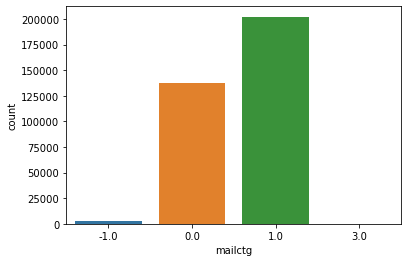

In [29]:
sns.countplot(x = "mailctg" , data  = train_df) 

In [30]:
#sns.countplot(x = "weight" , data  = train_df) 

Псотроим матрицу корреляции значений

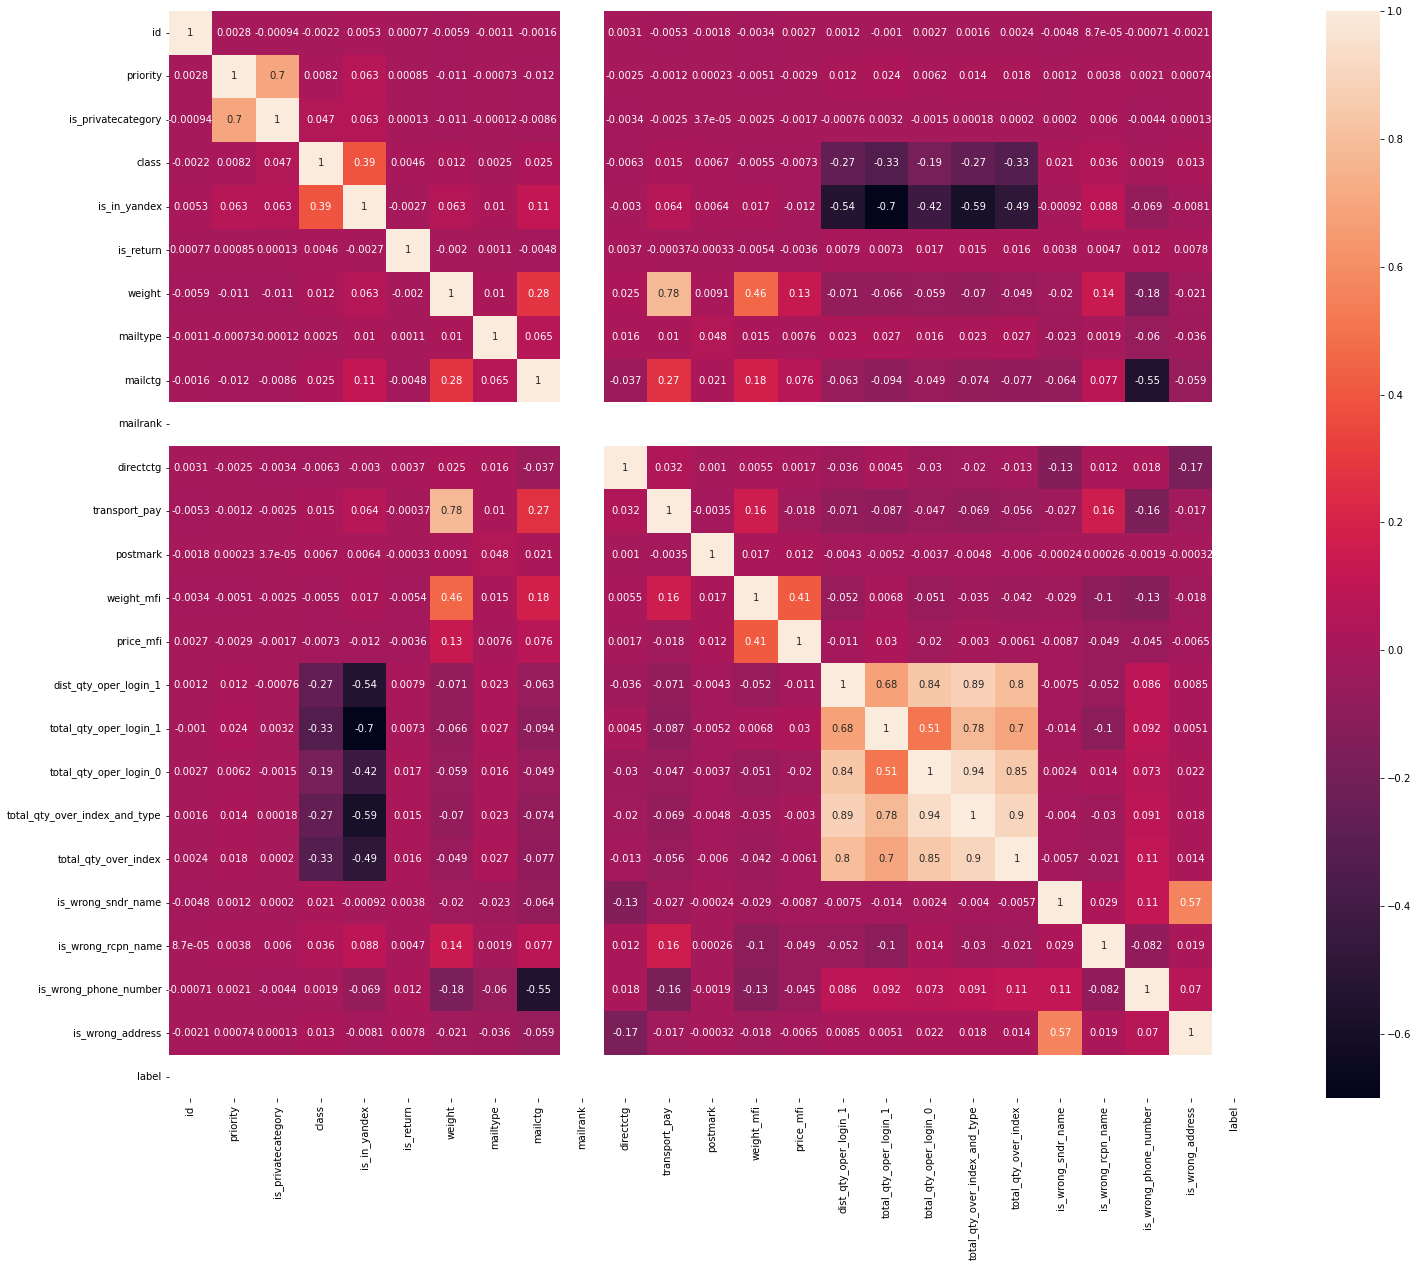

In [31]:
plt.rcParams['figure.figsize']=(25,20)

corr = train_df.iloc[:100000].corr()
g = sns.heatmap(corr, square = True, annot=True)

In [32]:
corr_fi = train_df.corrwith(train_df['label']).abs().sort_values(ascending=False)
corr_fi[:60]

label                            1.000000
mailctg                          0.392327
dist_qty_oper_login_1            0.348585
is_wrong_phone_number            0.327148
total_qty_oper_login_0           0.306460
total_qty_over_index_and_type    0.273815
class                            0.273672
total_qty_over_index             0.196221
transport_pay                    0.189127
total_qty_oper_login_1           0.166609
weight                           0.161405
weight_mfi                       0.118525
is_in_yandex                     0.075206
price_mfi                        0.054055
is_wrong_rcpn_name               0.043273
is_wrong_sndr_name               0.039891
is_wrong_address                 0.038827
is_privatecategory               0.023175
mailtype                         0.018932
priority                         0.014514
directctg                        0.011640
is_return                        0.004509
postmark                         0.001785
id                               0

## Выделим выборки

Обьединим список не нужных строк со списком строк типа object

In [33]:
# train
train_df.dtypes

id                                  int32
oper_type + oper_attr            category
index_oper                       category
type                             category
priority                          float32
is_privatecategory                   int8
class                             float32
is_in_yandex                         int8
is_return                            int8
weight                            float32
mailtype                          float32
mailctg                           float32
mailrank                          float32
directctg                         float32
transport_pay                     float32
postmark                          float32
name_mfi                         category
weight_mfi                        float32
price_mfi                         float32
dist_qty_oper_login_1             float32
total_qty_oper_login_1            float32
total_qty_oper_login_0            float32
total_qty_over_index_and_type     float32
total_qty_over_index              

In [34]:
#col_obj = train_df.select_dtypes(include=['object']).columns.values
col_obj = train_df.select_dtypes(include=['category']).columns.values
col_obj = list(set(col_obj) ^ set(["id", "label"]))
col_obj

['oper_type + oper_attr', 'index_oper', 'id', 'label', 'name_mfi', 'type']

In [35]:
X = train_df.drop(col_obj, axis = 1)
y = train_df[["label"]]

In [36]:
X = X.fillna(0)

In [37]:
# test
# test_df.head(1)

In [38]:
#col_test_obj = test_df.select_dtypes(include=['object']).columns.values
col_test_obj = test_df.select_dtypes(include=['category']).columns.values
col_test_obj = list(set(col_test_obj) ^ set(["id"]))
col_test_obj

['oper_type + oper_attr', 'index_oper', 'id', 'name_mfi', 'type']

In [39]:
test = test_df.drop(col_test_obj, axis = 1)

In [40]:
test = test.fillna(0)

## RandomForestClassifier

In [41]:
result = pd.read_csv("sample_solution.csv")

In [42]:
from sklearn.metrics import recall_score

In [44]:
result_lst = []
start_time = time.time()
for rs in range(31, 51):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = rs)
    
    # Обучение модели
    clf = RandomForestClassifier(random_state = 42)
    clf.fit(X_train, y_train)
    
    # Оценка точности
    pred = clf.predict(X_test)
    score = recall_score(y_test, pred, average = "macro" )
    
    # Предсказание
    test_pred = clf.predict(test)
    
    # Вывод
    test_df_pred = pd.DataFrame(test_pred)
    result['label'] = test_df_pred
    result.to_csv('221118_30_' + str(rs) + '_solution.csv', index=None, line_terminator='\n')
    
    vc = result["label"].value_counts()
    result_lst.append([rs, score, vc[0] , vc[1]])
    print(rs, score, vc[0] , vc[1], time.time() - start_time)

31 0.8743004678917561 3281964 718036 158.2994499206543
32 0.8705424734166822 3281277 718723 333.98550748825073
33 0.8755677658460586 3281251 718749 517.3230931758881
34 0.8734741673803657 3283124 716876 689.5410778522491
35 0.8736210340924988 3281993 718007 858.0387842655182
36 0.874443358271972 3281836 718164 1027.6631619930267
37 0.8733281286260259 3282773 717227 1195.5497391223907
38 0.8730557659309139 3284241 715759 1364.2374901771545
39 0.873524093214324 3281693 718307 1531.631531715393
40 0.8746165796475205 3280736 719264 1698.8294517993927
41 0.8725747676773979 3282282 717718 1862.0996730327606
42 0.8742842167173643 3282249 717751 2031.8796291351318
43 0.8743956647970721 3283894 716106 2207.9506998062134
44 0.8740976047682074 3282922 717078 2376.4537150859833
45 0.8747723769703 3282201 717799 2542.185425758362
46 0.8795995023188983 3283329 716671 2706.011044025421
47 0.8759176021249129 3282213 717787 2872.6061465740204
48 0.8729646570628826 3284279 715721 3044.891887664795
49 0.

In [53]:
result_sum = pd.read_csv("sample_solution.csv")

In [54]:
for rs in range(0, 51):
    result_rs = pd.read_csv('221118_30_' + str(rs) + '_solution.csv')
    result_sum['label'] = result_sum['label'] + result_rs['label']
    result_sum['label'].value_counts()
result_sum

,id,label
0,7815282,11
1,8443555,51
2,6352559,45
3,4921420,0
4,1420440,0
...,...,...
3999995,9030800,51
3999996,6275048,43
3999997,4701757,0
3999998,611153,0


In [55]:
result_sum['label'] = (result_sum['label'] + 48) // 50
result_sum

,id,label
0,7815282,1
1,8443555,1
2,6352559,1
3,4921420,0
4,1420440,0
...,...,...
3999995,9030800,1
3999996,6275048,1
3999997,4701757,0
3999998,611153,0


In [56]:
result_sum['label'].value_counts()

0    3094120
1     905880
Name: label, dtype: int64

In [57]:
result_sum.to_csv('221119_38_0-50_solution.csv', index=None, line_terminator='\n')